# Random CNN Features + Linear SVM on MNIST

In [1]:
!pip install -q torch torchvision scikit-learn matplotlib

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Python random seed:", SEED)
print("NumPy random seed:", SEED)
print("Torch random seed:", SEED)

Using device: cuda
Python random seed: 42
NumPy random seed: 42
Torch random seed: 42


In [3]:
class RandomCNN(nn.Module):
    """
    Simple CNN:
    Input: (1, 28, 28)
    Conv1: 16 filters, 3x3, padding=1 -> ReLU -> MaxPool(2x2)
           -> (16, 14, 14)
    Conv2: 32 filters, 3x3, padding=1 -> ReLU -> MaxPool(2x2)
           -> (32, 7, 7)
    Flatten -> Linear(32*7*7 -> 128) -> 128-dim features
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 7 * 7, 128)  # last-layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (N, 16, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 32, 7, 7)
        x = x.view(x.size(0), -1)             # flatten
        x = self.fc(x)                        # (N, 128)
        return x

model = RandomCNN().to(device)
print(model)

RandomCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=128, bias=True)
)


In [4]:
# MNIST normalization constants (standard)
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

batch_size = 256  # can adjust if GPU/CPU memory is small

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 470kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.52MB/s]

Train size: 60000
Test size: 10000


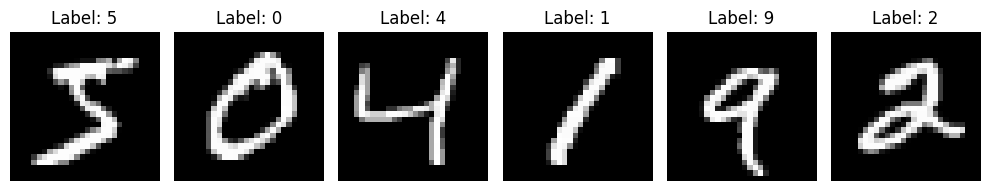

In [5]:
def show_examples(dataset, num_examples=6):
    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        img, label = dataset[i]
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img.squeeze().numpy(), cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(train_dataset, num_examples=6)

In [6]:
def extract_features(model, loader, device):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            features = model(x)         # (N, 128)
            features = features.cpu().numpy()
            all_features.append(features)
            all_labels.append(y.numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_features, all_labels

train_features, train_labels = extract_features(model, train_loader, device)
test_features, test_labels = extract_features(model, test_loader, device)

print("Train features shape:", train_features.shape)
print("Test  features shape:", test_features.shape)

Train features shape: (60000, 128)
Test  features shape: (10000, 128)


In [8]:
svm_clf = LinearSVC(
    C=1.0,
    max_iter=5000,
    random_state=SEED
)

print("Training LinearSVC on random features...")
svm_clf.fit(train_features, train_labels)

print("Done. Evaluating...")

train_pred = svm_clf.predict(train_features)
test_pred = svm_clf.predict(test_features)

train_acc = accuracy_score(train_labels, train_pred)
test_acc = accuracy_score(test_labels, test_pred)

print(f"Train accuracy: {train_acc * 100:.2f}%")
print(f"Test  accuracy: {test_acc * 100:.2f}%")

Training LinearSVC on random features...
Done. Evaluating...
Train accuracy: 94.21%
Test  accuracy: 94.37%


In [9]:
print("Classification report on test set:")
print(classification_report(test_labels, test_pred))

Classification report on test set:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.93      0.94      1032
           3       0.93      0.94      0.93      1010
           4       0.95      0.94      0.94       982
           5       0.94      0.93      0.93       892
           6       0.95      0.96      0.96       958
           7       0.93      0.93      0.93      1028
           8       0.91      0.93      0.92       974
           9       0.92      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

